# Libraries

In [1]:
import pandas as pd
import numpy as np
from os.path import exists
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Loading the Files

Download the csv files into the `data/` directory.

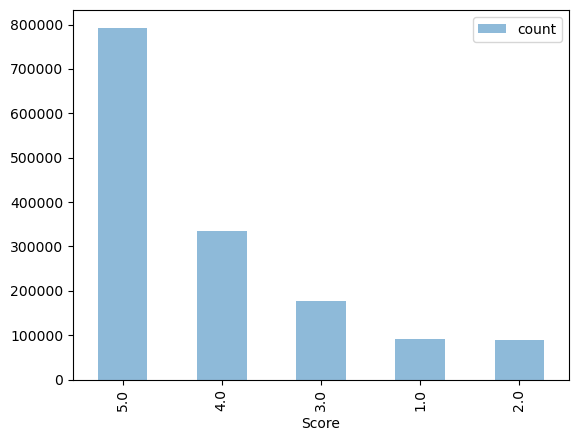

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
# Load data
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# Plot distribution of scores in the training set
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df, helpfulness_threshold=0.7):
    # Handle missing values for helpfulness
    df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(0)
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].replace([np.inf, -np.inf], 0).fillna(0)

    # Helpfulness Bucket based on threshold
    conditions = [
        (df['Helpfulness'] == 0),
        (df['Helpfulness'] > 0) & (df['Helpfulness'] <= helpfulness_threshold),
        (df['Helpfulness'] > helpfulness_threshold)
    ]
    choices = ['bad', 'medium', 'good']
    df['HelpfulnessBucket'] = np.select(conditions, choices, default='medium')

    # Convert HelpfulnessBucket to categorical codes for model compatibility
    df['HelpfulnessBucket'] = df['HelpfulnessBucket'].astype('category').cat.codes

    # Convert Time to relative time (years since the review was written)
    current_year = datetime.now().year
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['YearsAgo'] = current_year - df['Year']

    # Text-based features with missing value handling
    df['TextLength'] = df['Text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    
    # Caps Lock Words Count
    def caps_lock_count(text):
        words = str(text).split()
        return sum(1 for word in words if word.isupper() and len(word) > 1)
    
    df['CapsLockCount'] = df['Text'].apply(caps_lock_count)

    # Drop the original 'Time' and 'Year' columns if not needed
    df = df.drop(columns=['Time', 'Year'])
    
    return df

# Process the DataFrame
train = add_features_to(trainingSet)

# User Rating Habits
user_stats = train.groupby('UserId')['Score'].agg(
    UserAvgRating='mean',
    UserRatingVariance='var',
    UserReviewCount='count'
).fillna(0)

# Merge user stats back into main DataFrame
train = train.merge(user_stats, on='UserId', how='left')

# Process the submission set similarly
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train = train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split + Feature Selection

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=0.25,
    random_state=0
)

# Feature Selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'HelpfulnessBucket', 
            'YearsAgo', 'TextLength', 'SummaryLength', 'CapsLockCount', 'UserAvgRating', 
            'UserRatingVariance', 'UserReviewCount']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# TF-IDF Vectorization

In [5]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=200)  # Limiting to top 200 words

# Fit and transform the training, test, and submission sets
tfidf_train = vectorizer.fit_transform(X_train['Text'].fillna("")).toarray()
tfidf_test = vectorizer.transform(X_test['Text'].fillna("")).toarray()
tfidf_submission = vectorizer.transform(X_submission['Text'].fillna("")).toarray()

# Convert TF-IDF to DataFrames and concatenate with non-TF-IDF features
tfidf_columns = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train, columns=tfidf_columns)
tfidf_test_df = pd.DataFrame(tfidf_test, columns=tfidf_columns)
tfidf_submission_df = pd.DataFrame(tfidf_submission, columns=tfidf_columns)

# Scale and Combine Non-TF-IDF Features

In [6]:
# Scale non-TF-IDF features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)

# Convert scaled features back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_select.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_select.columns)
X_submission_scaled_df = pd.DataFrame(X_submission_scaled, columns=X_submission_select.columns)

# Concatenate scaled features with TF-IDF features
X_train_final = pd.concat([X_train_scaled_df.reset_index(drop=True), tfidf_train_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)
X_submission_final = pd.concat([X_submission_scaled_df.reset_index(drop=True), tfidf_submission_df.reset_index(drop=True)], axis=1)

# Calculate Class Weights

In [7]:
# Calculate class weights
unique_classes = np.unique(Y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_classes, y=Y_train)
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {1.0: 3.2628580633823443, 2.0: 3.3119425615412057, 3.0: 1.6890251760656807, 4.0: 0.8861776006491182, 5.0: 0.37437995698346554}


# Balanced Weighted KNN

In [8]:
class BalancedWeightedKNN(KNeighborsClassifier):
    def __init__(self, n_neighbors=5, weights='distance', p=2, class_weights=None, alpha=0.5):
        super().__init__(n_neighbors=n_neighbors, weights=weights, p=p)
        self.class_weights = class_weights
        self.alpha = alpha  # Parameter to control class weight influence

    def predict(self, X):
        # Get distances and indices of neighbors
        neighbors_distances, neighbors_indices = self.kneighbors(X)

        # Get weights for each neighbor
        neighbors_weights = 1 / (neighbors_distances + 1e-5)
        
        # Apply scaled class weights
        for i, indices in enumerate(neighbors_indices):
            for j, idx in enumerate(indices):
                neighbor_class = self._y[idx]
                class_weight = self.class_weights.get(neighbor_class, 1)
                neighbors_weights[i, j] *= class_weight ** self.alpha

        # Predict class by summing weighted votes
        predictions = []
        for i, weights in enumerate(neighbors_weights):
            class_votes = np.bincount(
                self._y[neighbors_indices[i]],
                weights=weights,
                minlength=len(self.classes_)
            )
            predictions.append(self.classes_[np.argmax(class_votes)])
        
        return np.array(predictions)

# Cross Validation for Hyperparameter Tuning

In [9]:
# Parameters to tune
param_options = {
    'n_neighbors': [200],
    'alpha': [0.25]
}

# Initialize variables to track best parameters and accuracy
best_accuracy = 0
best_params = {}

# Stratified K-Fold setup for better generalization
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Cross-validation loop
for n_neighbors in param_options['n_neighbors']:
    for alpha in param_options['alpha']:
        fold_accuracies = []
        
        # Stratified K-Fold Cross-Validation
        for train_index, val_index in kfold.split(X_train_final, Y_train):
            X_fold_train, X_fold_val = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
            Y_fold_train, Y_fold_val = Y_train.iloc[train_index], Y_train.iloc[val_index]
            
            # Initialize model with current parameters
            model = BalancedWeightedKNN(n_neighbors=n_neighbors, p=2, class_weights=class_weights_dict, alpha=alpha)
            model.fit(X_fold_train, Y_fold_train)
            
            # Evaluate on validation fold
            Y_val_predictions = model.predict(X_fold_val)
            fold_accuracy = accuracy_score(Y_fold_val, Y_val_predictions)
            fold_accuracies.append(fold_accuracy)
        
        # Average accuracy across folds
        avg_fold_accuracy = np.mean(fold_accuracies)
        print(f"Average Accuracy with n_neighbors={n_neighbors}, alpha={alpha}: {avg_fold_accuracy}")
        
        # Track the best parameters
        if avg_fold_accuracy > best_accuracy:
            best_accuracy = avg_fold_accuracy
            best_params = {'n_neighbors': n_neighbors, 'alpha': alpha}

print("Best parameters:", best_params)
print("Best average accuracy across folds:", best_accuracy)

Average Accuracy with n_neighbors=200, alpha=0.25: 0.6182611388638292
Best parameters: {'n_neighbors': 200, 'alpha': 0.25}
Best average accuracy across folds: 0.6182611388638292


# Train and Evaluate Balanced KNN Model

Final accuracy on testing set: 0.6173438610853782


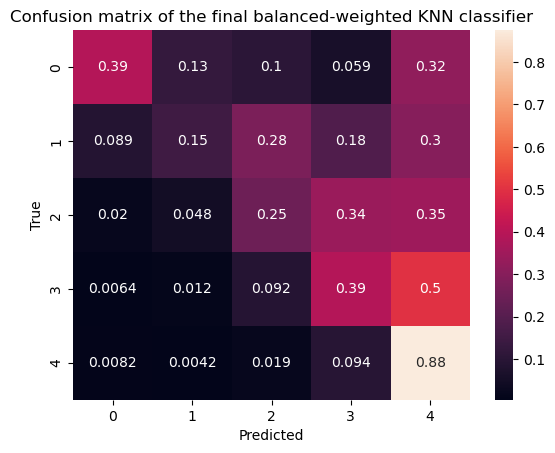

In [10]:
Y_test_predictions = model.predict(X_test_final)

# Final accuracy and confusion matrix
final_accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Final accuracy on testing set:", final_accuracy)
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the final balanced-weighted KNN classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [11]:
# Predict on Submission Set
X_submission['Score'] = model.predict(X_submission_final)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)